In [68]:
import numpy as np
import matplotlib.pyplot as plt

#Reading in BBM Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import pandas as pd

file_path = '/content/drive/My Drive/bbm_data.csv'
data = pd.read_csv(file_path, index_col=[0])

In [47]:
data.head()

,draft_id,player_name,position_name,overall_pick_number,position_pick_number,year
0,65219f4a-267e-4035-806a-646a3c1a846e,Stefon Diggs,WR,6,4,2023
1,65219f4a-267e-4035-806a-646a3c1a846e,Josh Allen,QB,19,1,2023
2,65219f4a-267e-4035-806a-646a3c1a846e,Keenan Allen,WR,30,16,2023
3,65219f4a-267e-4035-806a-646a3c1a846e,Christian Watson,WR,43,23,2023
4,65219f4a-267e-4035-806a-646a3c1a846e,T.J. Hockenson,TE,54,3,2023


In [48]:
data = data[['player_name', 'position_name', 'position_pick_number', 'year']]

#NFL Data Py

In [37]:
!pip install nfl_data_py

In [32]:
import nfl_data_py as nfl

In [15]:
nfl_data = nfl.import_weekly_data([2021, 2022, 2023], columns = ['player_display_name', 'position', 'fantasy_points', 'fantasy_points_ppr', 'season'])

Downcasting floats.


In [16]:
nfl_data['fantasy_points_half_ppr']=(nfl_data['fantasy_points']+nfl_data['fantasy_points_ppr'])/2

In [18]:
nfl_data = nfl_data[['player_display_name', 'fantasy_points_half_ppr', 'season']]

In [19]:
nfl_data

,player_display_name,fantasy_points_half_ppr,season
0,Tom Brady,27.160000,2021
1,Tom Brady,29.639999,2021
2,Tom Brady,28.680000,2021
3,Tom Brady,11.060000,2021
4,Tom Brady,37.740002,2021
...,...,...,...
5648,Zach Charbonnet,5.300000,2023
5649,Zach Charbonnet,1.600000,2023
5650,Zach Charbonnet,0.100000,2023
5651,Zach Charbonnet,6.600000,2023


#Fitting STAN Model

In [38]:
!pip3 install nest_asyncio
!python3 -m pip install pystan
!python -m pip install Cython

In [39]:
import nest_asyncio
nest_asyncio.apply()

In [20]:
merged_data = pd.merge(nfl_data, data, how='left', left_on=['player_display_name', 'season'], right_on=['player_name', 'year'])
merged_data = merged_data[['player_display_name', 'fantasy_points_half_ppr', 'positional_adp']]

In [59]:
mean_fantasy_points_by_year = nfl_data.groupby(['player_display_name', 'season'])['fantasy_points_half_ppr'].mean().reset_index()

mean_position_pick_number_by_year = data.groupby(['player_name', 'year', 'position_name'])['position_pick_number'].mean().reset_index()

merged_data_by_year = mean_fantasy_points_by_year.merge(
    mean_position_pick_number_by_year,
    left_on=['player_display_name', 'season'],
    right_on=['player_name', 'year'],
    how='inner'
).drop(columns=['player_name', 'season'])

In [51]:
merged_data.drop(['player_name'], axis=1, inplace=True)

In [60]:
merged_data_by_year

,player_display_name,fantasy_points_half_ppr,year,position_name,position_pick_number
0,A.J. Brown,12.292857,2021,WR,6.687597
1,A.J. Brown,14.135000,2022,WR,10.732179
2,A.J. Brown,13.917647,2023,WR,6.100004
3,A.J. Green,7.635294,2021,WR,75.090923
4,A.J. Green,3.815384,2022,WR,83.498659
...,...,...,...,...,...
1384,Zay Jones,6.062500,2021,WR,96.500000
1385,Zay Jones,10.294445,2022,WR,82.752882
1386,Zay Jones,6.788889,2023,WR,56.383503
1387,Zonovan Knight,7.500000,2022,RB,58.250000


In [85]:
df_wr = merged_data_by_year[merged_data_by_year['position_name'] == 'WR']

stan_data = {
    'N': len(df_wr),
    'position_pick_number': df_wr['position_pick_number'].values,
    'fantasy_points_half_ppr': df_wr['fantasy_points_half_ppr'].values
}

In [86]:
stan_code = """
data {
  int<lower=0> N; // Number of data points
  vector[N] position_pick_number; // Predictor
  vector[N] fantasy_points_half_ppr; // Response
}

parameters {
  real alpha; // Intercept
  real beta1; // Linear term
  real beta2; // Quadratic term
  real<lower=0> sigma; // Standard deviation of the residuals
}

model {
  // Priors
  alpha ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  sigma ~ normal(0, 5);

  // Likelihood
  fantasy_points_half_ppr ~ normal(alpha + beta1 * position_pick_number + beta2 * square(position_pick_number), sigma);
}
"""

# Compile the model
model = stan.build(stan_code, data=stan_data)

# Sample from the posterior
fit = model.sample(num_chains=4, num_samples=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1901/8000)
Sampling:  25% (2002/8000)
Sampling:  26% (2101/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/80

In [87]:
fit_df = fit.to_frame()
print(fit_df.describe())

parameters         lp__  accept_stat__   stepsize__  treedepth__  \
count       4000.000000    4000.000000  4000.000000  4000.000000   
mean        -824.079180       0.934778     0.006322     7.495250   
std            1.341397       0.094355     0.000174     1.775039   
min         -832.856652       0.127771     0.006085     1.000000   
25%         -824.764414       0.909695     0.006256     7.000000   
50%         -823.771968       0.974592     0.006313     8.000000   
75%         -823.097413       0.996787     0.006379     9.000000   
max         -822.161135       1.000000     0.006576    10.000000   

parameters  n_leapfrog__  divergent__     energy__        alpha        beta1  \
count         4000.00000       4000.0  4000.000000  4000.000000  4000.000000   
mean           370.52650          0.0   826.063911    14.838290    -0.177775   
std            246.46531          0.0     1.934355     0.496029     0.021831   
min              1.00000          0.0   822.502874    13.263879    

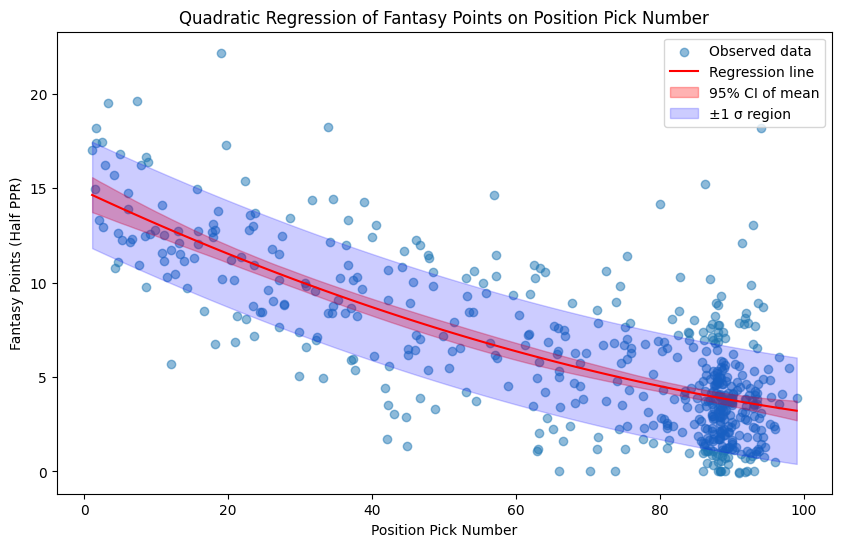

In [88]:
alpha_samples = fit['alpha']
beta1_samples = fit['beta1']
beta2_samples = fit['beta2']
sigma_samples = fit['sigma']

x = np.linspace(min(stan_data['position_pick_number']), max(stan_data['position_pick_number']), 100)
y_mean = alpha_samples.mean() + beta1_samples.mean() * x + beta2_samples.mean() * np.square(x)

y_lower = np.percentile(alpha_samples + beta1_samples * x[:, None] + beta2_samples * np.square(x)[:, None], 2.5, axis=1)
y_upper = np.percentile(alpha_samples + beta1_samples * x[:, None] + beta2_samples * np.square(x)[:, None], 97.5, axis=1)

sigma_mean = sigma_samples.mean()
y_sigma_lower = y_mean - sigma_mean
y_sigma_upper = y_mean + sigma_mean

plt.figure(figsize=(10, 6))
plt.scatter(stan_data['position_pick_number'], stan_data['fantasy_points_half_ppr'], alpha=0.5, label='Observed data')
plt.plot(x, y_mean, color='red', label='Regression line')
plt.fill_between(x, y_lower, y_upper, color='red', alpha=0.3, label='95% CI of mean')
plt.fill_between(x, y_sigma_lower, y_sigma_upper, color='blue', alpha=0.2, label='±1 σ region')
plt.xlabel('Position Pick Number')
plt.ylabel('Fantasy Points (Half PPR)')
plt.title('Quadratic Regression of Fantasy Points on Position Pick Number')
plt.legend()
plt.show()